In [56]:
%matplotlib inline

import bt
import numpy as np

In [57]:
data = bt.get("spy,vti,upro", start="2015-01-01")
print(data.head())

                   spy        vti       upro
Date                                        
2015-01-02  171.568085  88.588013  10.509111
2015-01-05  168.469559  87.065811   9.943330
2015-01-06  166.882797  86.212746   9.673944
2015-01-07  168.962357  87.241455  10.030743
2015-01-08  171.960571  88.780373  10.559972


In [58]:
INITIAL_CAPITAL = 180_000
MONTHLY_INFLUX = 7_000

In [59]:
spy = bt.Strategy('spy', [
    bt.algos.RunMonthly(),
    bt.algos.SelectThese(["spy"]),
    bt.algos.WeighEqually(),
    bt.algos.CapitalFlow(MONTHLY_INFLUX),
    bt.algos.Rebalance(),
])
spy_test = bt.Backtest(spy, data, initial_capital=INITIAL_CAPITAL)

In [60]:
vti_upro = bt.Strategy('vti+upro', [
    bt.algos.RunMonthly(),
    bt.algos.SelectThese(["vti", "upro"]),
    bt.algos.WeighEqually(),
    bt.algos.CapitalFlow(MONTHLY_INFLUX),
    bt.algos.Rebalance(),
])
vti_upro_test = bt.Backtest(vti_upro, data, initial_capital=INITIAL_CAPITAL)

In [61]:
class BuyOnlyRebalance(bt.algos.Algo):
    def __call__(self, target):
        if "weights" not in target.temp: return True

        targets = target.temp["weights"]

        total_capital = target.value
        current_positions_value = 0
        for cname in target.children:
            c = target.children[cname]
            if target.fixed_income:
                current_positions_value += c.notional_value
            else:
                current_positions_value += c.value

        # Available cash for new purchases
        available_cash = total_capital - current_positions_value
        assert available_cash > 0, "we have influx of capital each cycle..."
        if available_cash <= 0: return True

        target_values = {asset: total_capital * weight for asset, weight in targets.items()}
        # Calculate how much to *buy* of each asset
        for asset, target_value in target_values.items():
            # Get current value of this asset
            if asset in target.children:
                c = target.children[asset]
                current_value = c.notional_value if target.fixed_income else c.value
            else:
                current_value = 0

            # Calculate how much more we need to buy
            amount_to_buy = target_value - current_value
            
            # Only buy if we have positive amount and available cash
            if amount_to_buy > 0 and available_cash > 0:
                # Limit by available cash
                amount_to_buy = min(amount_to_buy, available_cash)
                
                # Allocate the amount
                target.allocate(amount_to_buy, child=asset, update=False)
                
                # Reduce available cash
                available_cash -= amount_to_buy
        # Now update
        target.root.update(target.now)
        strat = target.root
        # print(f"{strat.price=} {strat.value=} {strat.capital=} {strat.weight=} {strat.children['vti'].weight=}")
        
        return True

vti_upro_buy_only = bt.Strategy('vti+upro buy only', [
    bt.algos.RunMonthly(),
    bt.algos.SelectThese(["vti", "upro"]),
    bt.algos.WeighEqually(),
    bt.algos.CapitalFlow(MONTHLY_INFLUX),
    BuyOnlyRebalance(),
])
vti_upro_buy_only_test = bt.Backtest(vti_upro_buy_only, data, initial_capital=INITIAL_CAPITAL)

In [62]:
vti_upro_80 = bt.Strategy("vti+upro 80% upro", [
    bt.algos.RunMonthly(),
    bt.algos.SelectThese(["vti", "upro"]),
    bt.algos.WeighSpecified(vti=.2, upro=.8),
    bt.algos.CapitalFlow(MONTHLY_INFLUX),
    BuyOnlyRebalance(),
])
vti_upro_80_test = bt.Backtest(vti_upro_80, data, initial_capital=INITIAL_CAPITAL)

In [63]:
upro = bt.Strategy("upro", [
    bt.algos.RunMonthly(),
    bt.algos.SelectThese(["upro"]),
    bt.algos.WeighEqually(),
    bt.algos.CapitalFlow(MONTHLY_INFLUX),
    bt.algos.Rebalance(),
])
upro_test = bt.Backtest(upro, data, initial_capital=INITIAL_CAPITAL)

In [64]:
res = bt.run(spy_test, upro_test, vti_upro_test, vti_upro_buy_only_test, vti_upro_80_test)
res.display()

100%|██████████| 5/5 [00:00<00:00,  6.04it/s]


Stat                 spy         upro        vti+upro    vti+upro buy only    vti+upro 80% upro
-------------------  ----------  ----------  ----------  -------------------  -------------------
Start                2015-01-01  2015-01-01  2015-01-01  2015-01-01           2015-01-01
End                  2025-09-12  2025-09-12  2025-09-12  2025-09-12           2025-09-12
Risk-free rate       0.00%       0.00%       0.00%       0.00%                0.00%

Total Return         282.21%     914.33%     623.55%     555.56%              754.20%
Daily Sharpe         0.79        0.68        0.71        0.68                 0.67
Daily Sortino        1.23        1.05        1.09        1.04                 1.04
CAGR                 13.35%      24.18%      20.32%      19.22%               22.20%
Max Drawdown         -33.73%     -76.83%     -57.77%     -58.09%              -69.42%
Calmar Ratio         0.40        0.31        0.35        0.33                 0.32

MTD                  1.92%       5.3

<Axes: title={'center': 'Equity Progression'}>

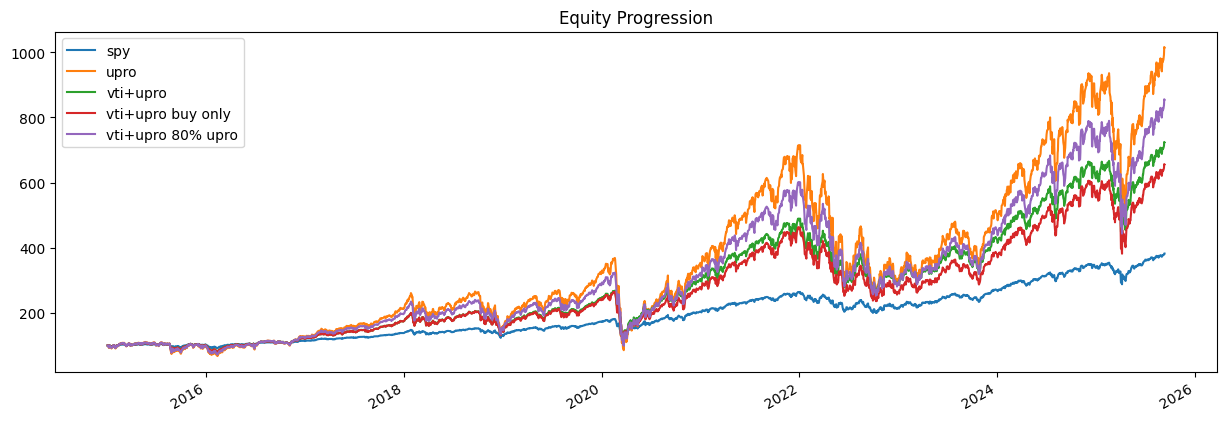

In [65]:
res.plot()